In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

## Exploratory Climate Analysis

In [12]:
#Exploring the data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
#Exploring the data
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
#Which is the last date recorded?
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [17]:
# Earliest Date?
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [18]:
# Calculate the date 1 year ago from the last data point in the database
query_limit = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Query Date: ", query_limit)

Query Date:  2016-08-23


In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp =(session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= query_limit).all())

df = pd.DataFrame(prcp, columns=['station','date', 'prcp'])
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()


,station,prcp
date,,
2016-08-23,USC00519397,0.00
2016-08-24,USC00519397,0.08
2016-08-25,USC00519397,0.08
2016-08-26,USC00519397,0.00
2016-08-27,USC00519397,0.00


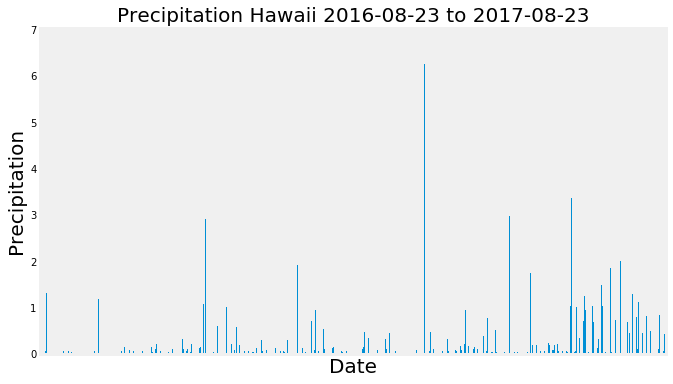

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="bar", figsize=(10,6), legend = False)
plt.title("Precipitation Hawaii 2016-08-23 to 2017-08-23").set_size(20)
plt.xlabel("Date").set_size(20)

plt.ylabel("Precipitation").set_size(20)
plt.grid()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig("prcp.png")
plt.show()
plt.close()

In [21]:
prcp_list = df["prcp"].tolist()

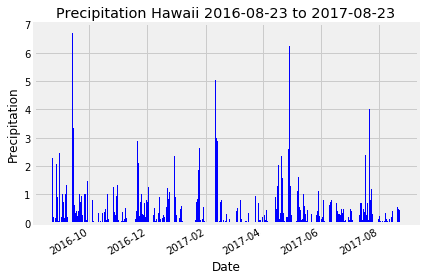

In [22]:
#Another way to create this figure
fig, ax = plt.subplots()
ax.bar(df.index.get_values(), prcp_list,color='b',align='center', label="Precipitation")
ax.xaxis_date()
fig.autofmt_xdate()
plt.title('Precipitation Hawaii 2016-08-23 to 2017-08-23')
plt.xlabel('Date')
plt.ylabel("Precipitation")
plt.tight_layout()
plt.savefig("prcp2.png")
plt.show()

In [23]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).distinct(Measurement.station).count()
print("Total number of stations is "+ str(number_stations))

Total number of stations is 9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
top_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).limit(1).scalar()
print ( "Station which has the highest number of observations is  " + str(top_station))

Station which has the highest number of observations is  USC00519281


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

data_top_station = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == top_station).all()
data_top_station

[('USC00519281', 70.0),
 ('USC00519281', 62.0),
 ('USC00519281', 74.0),
 ('USC00519281', 75.0),
 ('USC00519281', 74.0),
 ('USC00519281', 76.0),
 ('USC00519281', 69.0),
 ('USC00519281', 66.0),
 ('USC00519281', 70.0),
 ('USC00519281', 75.0),
 ('USC00519281', 64.0),
 ('USC00519281', 60.0),
 ('USC00519281', 61.0),
 ('USC00519281', 68.0),
 ('USC00519281', 64.0),
 ('USC00519281', 66.0),
 ('USC00519281', 67.0),
 ('USC00519281', 70.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 69.0),
 ('USC00519281', 60.0),
 ('USC00519281', 75.0),
 ('USC00519281', 75.0),
 ('USC00519281', 65.0),
 ('USC00519281', 75.0),
 ('USC00519281', 69.0),
 ('USC00519281', 67.0),
 ('USC00519281', 66.0),
 ('USC00519281', 69.0),
 ('USC00519281', 72.0),
 ('USC00519281', 67.0),
 ('USC00519281', 65.0),
 ('USC00519281', 64.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 68.0),
 ('USC00519281', 69.0),
 ('USC00519281', 66.0),
 ('USC00519281', 69.0),
 ('USC00519281', 61.0),
 ('USC00519281',

In [28]:
#Highest temperature
max_top_station = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_station).all()
max_top_station

[(85.0)]

In [29]:
#Lowesttemperature
min_top_station = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_station).all()
min_top_station

[(54.0)]

In [30]:
#Average temperature
#Highest temperature
avg_top_station = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_station).all()
avg_top_station

[(71.66378066378067)]

In [31]:
# Choose the station with the highest number of temperature observations.
top_temp_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).limit(1).scalar()
print ( "Station which has the highest number of observations is  " + str(top_temp_station))

Station which has the highest number of observations is  USC00519281


In [32]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Which is the last date recorded?
last_date_top = session.query(Measurement.date).filter(Measurement.station == top_station).order_by(Measurement.date.desc()).first()
last_date_top

('2017-08-18')

In [33]:
# Calculate the date 1 year ago from the last data point in the database
query_limit_top = dt.date(2017,8,18) - dt.timedelta(days=365)
print("Query Date: ", query_limit_top)

Query Date:  2016-08-18


In [34]:
temp =(session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_limit_top).all())

#df_temp = pd.DataFrame(temp, columns=['date', 'prcp'])
#df_temp = df_temp.dropna()

#df_temp.head()
temp

[('2016-08-18', 80.0),
 ('2016-08-19', 77.0),
 ('2016-08-20', 80.0),
 ('2016-08-21', 76.0),
 ('2016-08-22', 77.0),
 ('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 79.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 79.0),
 ('2016-09-06', 76.0),
 ('2016-09-07', 76.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 78.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 78.0),
 ('2016-09-13', 78.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 80.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 81.0),
 ('2016-09-19', 77.0),
 ('2016-09-20', 77.0),
 ('2016-09-21', 78.0),
 ('2016-09-22', 76.0),
 ('2016-09-23', 82.0),
 ('2016-09-24', 81.0),
 ('2016-09-25', 78.0),
 ('2016-09-26', 80.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 79.0),
 ('2016-09-29', 80.0),
 ('2016-09-

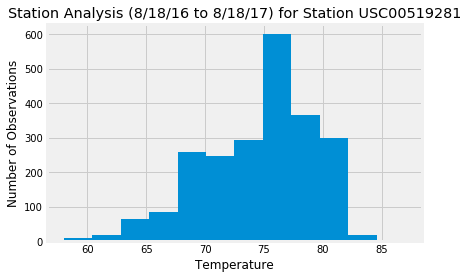

In [38]:
temp_df=pd.DataFrame(temp)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Number of Observations")
plt.title("Station Analysis (8/18/16 to 8/18/17) for Station " + top_temp_station)
plt.savefig("temp.png")
plt.show()

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp=[]
start_date = '2017-08-11'
end_date = '2017-08-18'
def calc_temps(start_date, end_date):
    results=session.query(func.max(Measurement.tobs).label("max_tobs"), \
                          func.min(Measurement.tobs).label("min_tobs"),\
                          func.avg(Measurement.tobs).label("avg_tobs")).\
                          filter(Measurement.date.between(start_date , end_date))  
    res = results.one()
    res
    tmax = res.max_tobs
    tmin= res.min_tobs
    tavg= res.avg_tobs
    temp.append(tmax)
    temp.append(tmin)
    temp.append(tavg)
calc_temps(start_date, end_date)
temp

[84.0, 70.0, 78.17647058823529]

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

[84.0, 70.0, 78.17647058823529]

In [50]:
tavg=temp[2]
tmin=temp[1]
tmax=temp[0]

C:\Users\Jojo\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


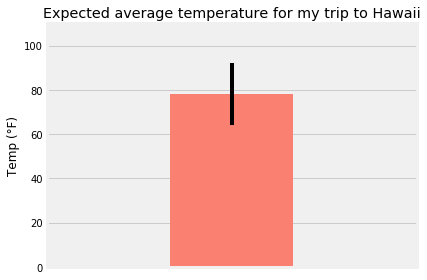

In [53]:
fig = plt.figure()
plt.bar( 1,tavg, color = 'salmon', yerr = tmax-tmin, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Expected average temperature for my trip to Hawaii')
plt.ylabel("Temp (°F)")
plt.tight_layout()
plt.show()
fig.savefig('Trip_temp.png')